In [ ]:
import os
import numpy as np
from google.colab.patches import cv2_imshow
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K
from tensorflow import keras
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Layer, Input, Reshape, ReLU
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout
from tensorflow.keras.layers import Dropout, Dense, StringLookup
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model

In [ ]:
!unzip OCR_Data.zip
!unzip data.zip

In [ ]:
def plot_acc_loss(history):
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    fig = plt.figure(figsize=(10, 3))
    fig.add_subplot(1, 2, 1)
    plt.plot(train_acc)
    plt.plot(val_acc)
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')

    fig.add_subplot(1, 2, 2)
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')

In [ ]:
def plot_result_class(x, y, preds):
    batch_size = preds.shape[0]
    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(batch_size):
        img = x[i]
        label = np.argmax(y[i])
        pred = np.argmax(preds[i])
        title = f"Pred: {pred} | True: {label}"

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
    plt.show()

In [ ]:
def plot_loss(history, title):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.title(title)
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.grid()
    plt.show()


In [ ]:
def plot_result(batch, pred_texts=None):
    batch_images = batch["image"]
    batch_labels = batch["label"]
    batch_size = len(batch_images)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(batch_size):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T

        if pred_texts:
            title = f"Pred: {pred_texts[i]}"
        else:
            title = f"True: {orig_texts[i]}"

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
    plt.show()

### Classification

In [ ]:
data_dir = "/content/data"
credit_dir = "/content/data/credit_card"
meli_dir = "/content/data/meli_card"

credit_dir_files = os.listdir(credit_dir)
meli_dir_files =  os.listdir(meli_dir)

credit_card_label = 0
meli_card_label = 1
for file_name in credit_dir_files:
  src_path = os.path.join(credit_dir, file_name)
  os.rename(src_path, os.path.join(credit_dir, f"{credit_card_label}_{file_name}"))

for file_name in meli_dir_files:
  src_path = os.path.join(meli_dir, file_name)
  os.rename(src_path, os.path.join(meli_dir, f"{meli_card_label}_{file_name}"))

In [ ]:
dataset_dir = "/content/data"
datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input,
    rescale=1./255,
    validation_split=0.2,
)

train_set = datagen.flow_from_directory(
    dataset_dir,
    batch_size=16,
    target_size=(50, 200),
    class_mode='categorical',
    shuffle=True,
    subset='training',
)

val_set = datagen.flow_from_directory(
    dataset_dir,
    batch_size=16,
    target_size=(50, 200),
    class_mode='categorical',
    shuffle=True,
    subset='validation',
)

In [ ]:
model1 = keras.Sequential(
    [
        keras.Input(shape=(50,200,3)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(2, activation="softmax"),
    ]
)

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 198, 32)       896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 99, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 97, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 48, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 33792)             0         
                                                                 
 dropout (Dropout)           (None, 33792)             0

In [ ]:
model1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history1 = model1.fit(train_set, validation_data=val_set, batch_size=16, epochs=10)

Epoch 1/10
3/3 [==============================] - 10s 265ms/step - loss: 0.6545 - accuracy: 0.6471 - val_loss: 0.4737 - val_accuracy: 0.7500
Epoch 2/10
3/3 [==============================] - 1s 335ms/step - loss: 0.3898 - accuracy: 0.8235 - val_loss: 0.4266 - val_accuracy: 0.8750
Epoch 3/10
3/3 [==============================] - 1s 223ms/step - loss: 0.2427 - accuracy: 0.9118 - val_loss: 0.5293 - val_accuracy: 0.8750
Epoch 4/10
3/3 [==============================] - 1s 367ms/step - loss: 0.2008 - accuracy: 0.8824 - val_loss: 0.8854 - val_accuracy: 0.6250
Epoch 5/10
3/3 [==============================] - 1s 121ms/step - loss: 0.2058 - accuracy: 0.9412 - val_loss: 0.2194 - val_accuracy: 0.8750
Epoch 6/10
3/3 [==============================] - 1s 397ms/step - loss: 0.0715 - accuracy: 0.9706 - val_loss: 0.2926 - val_accuracy: 0.8750
Epoch 7/10
3/3 [==============================] - 1s 318ms/step - loss: 0.1410 - accuracy: 0.9118 - val_loss: 0.1710 - val_accuracy: 0.8750
Epoch 8/10
3/3 [===

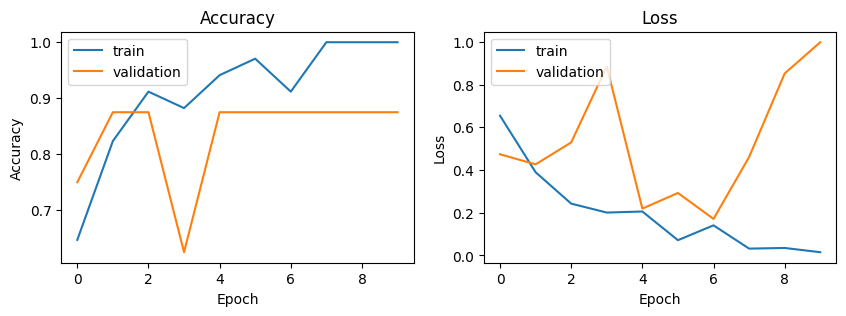

In [ ]:
plot_acc_loss(history1)

In [ ]:
X_eval, Y_eval = next(val_set)
print(X_eval.shape)

(8, 50, 200, 3)


In [ ]:
preds = model1.predict(X_eval)

1/1 [==============================] - 0s 102ms/step


In [ ]:
plot_result_class(X_eval, Y_eval, preds)

In [ ]:
X_eval1 =  cv2.imread("/content/test.jpg")
Y_eval1 = np.array([[0. , 1.]])
X_eval1 = cv2.resize(X_eval1,(50,200))
X_eval1 = X_eval1.reshape((1 , 50 , 200 , 3))
print(X_eval1.shape)
pred_test= model1.predict(X_eval1)

In [ ]:
print(pred_test)
plot_result_class(X_eval1, Y_eval1, pred_test)

### Preprocess image


In [ ]:
def reorder(poly):
    # sort the four coordinates of the polygon, points in poly should be sorted clockwise
    # First find the lowest point
    p_lowest = np.argmax(poly[:, 1])
    if np.count_nonzero(poly[:, 1] == poly[p_lowest, 1]) == 2:
        #if the bottom line is parallel to x-axis, then p0 must be the upper-left corner
        p0_index = np.argmin(np.sum(poly, axis=1))
        p1_index = (p0_index + 1) % 4
        p2_index = (p0_index + 2) % 4
        p3_index = (p0_index + 3) % 4
        return poly[[p1_index,p0_index, p3_index,p2_index]]
    else:
        #find the point that sits right to the lowest point
        p_lowest_right = (p_lowest - 1) % 4
        p_lowest_left = (p_lowest + 1) % 4
        angle = np.arctan(-(poly[p_lowest][1] - poly[p_lowest_right][1])/(poly[p_lowest][0] - poly[p_lowest_right][0]))
        # assert angle > 0
        if angle <= 0:
            print(angle, poly[p_lowest], poly[p_lowest_right])
        if angle/np.pi * 180 > 45:
            # this point is p2
            p2_index = p_lowest
            p1_index = (p2_index - 1) % 4
            p0_index = (p2_index - 2) % 4
            p3_index = (p2_index + 1) % 4
            return poly[[p1_index,p0_index, p3_index,p2_index]]
        else:
            #this point is p3
            p3_index = p_lowest
            p0_index = (p3_index + 1) % 4
            p1_index = (p3_index + 2) % 4
            p2_index = (p3_index + 3) % 4
            return poly[[p1_index,p0_index, p3_index,p2_index]]

In [ ]:
def scan(img , kernel_size ,t_lower , t_higher , output_name):
  # converting to grayscale
  gray_im = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # apply gaussian blur to remove noise
  blurred_im = cv2.GaussianBlur(gray_im, kernel_size, 0)
  edges_im_blurred = cv2.Canny(blurred_im, t_lower, t_higher)

  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
  dilated_im = cv2.dilate(edges_im_blurred, kernel, iterations=1)

  contours, hierarchy = cv2.findContours(dilated_im, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  card_contour = max(contours, key=cv2.contourArea)
  peri = cv2.arcLength(card_contour, True)
  card_contour = cv2.approxPolyDP(card_contour, 0.03 * peri, True)
  img_copy = img.copy()
  cv2.drawContours(img_copy, [card_contour], -1, (0, 0, 255), 2)

  v_list = reorder(card_contour.reshape(4, 2)).astype(np.float32)
  # calculate width and height of the rectangle
  w = np.sqrt(((v_list[0][0] - v_list[1][0]) ** 2) + ((v_list[0][1] - v_list[1][1]) ** 2))
  h = np.sqrt(((v_list[0][0] - v_list[3][0]) ** 2) + ((v_list[0][1] - v_list[3][1]) ** 2))
  # converting old vertices to new vertices
  new_v_list = np.array([[0, 0], [w, 0], [w, h], [0, h]], dtype=np.float32)
  # get transform function
  per_trans = cv2.getPerspectiveTransform(v_list, new_v_list)
  # apply transform on the image
  im_copy_2 = img.copy()
  warped_per = cv2.warpPerspective(im_copy_2, per_trans, (int(w), int(h)))
  h  = warped_per.shape[0]
  w = warped_per.shape[1]
  if h > w :
    warped_per = cv2.rotate(warped_per, cv2.ROTATE_90_CLOCKWISE)
  return warped_per

In [ ]:
img = cv2.imread("6.jpeg")
out = scan(img , (13,13) , 0 , 50 , 'img1_out.jpg')
cv2.imwrite("/content/out.jpg" , out)

-0.5285562986942396 [747 531] [360 305]


True

In [ ]:
def crop(image , card_type):
  if card_type == "credit":
    img = cv2.resize(image, (400, 300))
    img = img[ 170 : 213 , 35 : 388]
  elif card_type=="meli":
    img = cv2.resize(image, (400, 300))
    img = img[70 : 100, 220 : 325]
  else:
    raise ValueError("Invalid card type")
  return img

### OCR

In [ ]:
nums = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
char_to_num = StringLookup(vocabulary=nums)

num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(),
    invert=True,
)


In [ ]:
def read_dataset(directory):
    data_dir = Path(directory)
    images = sorted(list(map(str, list(data_dir.glob("*.jpg")))))
    labels = [img.split(os.path.sep)[-1].split(".jpg")[0] for img in images]
    return images, labels

In [ ]:
def split_data(images, labels, train_size):
    # size of the dataset
    size = len(images)


    indices = np.arange(size)
    np.random.shuffle(indices)

    # ize of training samples
    train_samples = int(size * train_size)

    # split data into training and validation sets
    x_train = images[indices[:train_samples]]
    y_train = labels[indices[:train_samples]]

    x_val = images[indices[train_samples:]]
    y_val = labels[indices[train_samples:]]

    return x_train, y_train, x_val, y_val

In [ ]:
def input_preprocess(path, label):
    img = tf.io.read_file(path)

    img = tf.io.decode_png(img, channels=3)

    img = tf.image.random_jpeg_quality(img, 40, 80)

    img = tf.image.convert_image_dtype(img, tf.float32)

    img = tf.image.resize(img, [50, 200])

    img = tf.transpose(img, perm=[1, 0, 2])

    # Map the characters in label to numbers
    label = char_to_num(
        tf.strings.unicode_split(label, input_encoding="UTF-8")
    )

    # our model input
    return {"image": img, "label": label}


In [ ]:
def get_generators(dataset, batch_size):
    x_train, y_train, x_val, y_val = dataset

    # Train
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

    train_dataset = (
        train_dataset.map(
            input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
        )
        .batch(batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

    # Validation
    val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))

    val_dataset = (
        val_dataset.map(
            input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
        )
        .batch(batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

    return train_dataset, val_dataset

In [ ]:
def get_numbers_predictions(pred , max_length):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]

    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :max_length]
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

In [ ]:
class CTCLayer(Layer):
    def __init__(self, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.loss_fn = K.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [ ]:
def build_model(input_shape):
    # Inputs
    input_img = Input(
        shape=input_shape,
        name="image",
        dtype="float32",
    )
    input_label = Input(
        shape=(None,),
        name="label",
        dtype="float32",
    )

    # Conv Block 1
    x = Conv2D(
        filters=32,
        kernel_size=(3, 3),
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = ReLU(name="ReLU1")(x)
    x = MaxPool2D(
        pool_size=(2, 2),
        name="Pool1"
    )(x)
    x = Dropout(0.25)(x)

    # Conv Block 2
    x = Conv2D(
        filters=64,
        kernel_size=(3, 3),
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = ReLU(name="ReLU2")(x)
    x = MaxPool2D(
        pool_size=(2, 2),
        name="Pool2"
    )(x)
    x = Dropout(0.25)(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model"
    new_shape = ((input_shape[0] // 4), (input_shape[1] // 4) * 64)

    x = Reshape(target_shape=new_shape, name="Reshape")(x)
    x = Dense(64, activation="relu", name="Dense1")(x)
    x = Dropout(0.25, name="Dropout1")(x)

    # RNNs
    x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = Dense(
        12, # vocab len
        activation="softmax",
        name="Dense2",
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="CTC_Loss")(input_label, x)

    # Define the model
    model = Model(
        inputs=[input_img, input_label],
        outputs=output,
    )
    return model

In [ ]:
model = build_model(
    input_shape=(200, 5, 3),
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 5, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 5, 32)   896         ['image[0][0]']                  
                                                                                                  
 ReLU1 (ReLU)                   (None, 200, 5, 32)   0           ['Conv1[0][0]']                  
                                                                                                  
 Pool1 (MaxPooling2D)           (None, 100, 2, 32)   0           ['ReLU1[0][0]']                  
                                                                                              

In [ ]:

credit_path = '/content/OCR_Data/credit'
national_path = '/content/OCR_Data/meli'

credit_ds = read_dataset(credit_path)
national_ds = read_dataset(national_path)


In [ ]:
cred_x_train, cred_y_train, cred_x_val, cred_y_val = split_data(
    images=np.array(credit_ds[0]),
    labels=np.array(credit_ds[1]),
    train_size=0.8,
)


In [ ]:
cred_train_dataset, cred_val_dataset = get_generators(
    (cred_x_train, cred_y_train, cred_x_val, cred_y_val),
    16,
)

In [ ]:
nat_x_train, nat_y_train, nat_x_val, nat_y_val = split_data(
    images=np.array(national_ds[0]),
    labels=np.array(national_ds[1]),
    train_size=0.8,
)

In [ ]:
nat_train_dataset, nat_val_dataset = get_generators(
    (nat_x_train, nat_y_train, nat_x_val, nat_y_val),
    16,
)

In [ ]:
model = build_model(
    input_shape=(200, 50, 3),
)

model.compile(optimizer="Adam" )

In [ ]:
def train_and_save(epochs , train_dataset , validation_dataset , type_card ):
  # Train the model
  history = model.fit(
      train_dataset,
      validation_data=validation_dataset,
      epochs=epochs
  )
  # save the model
  model.save(f"/content/saved_model_{type_card}")
  return history


history = train_and_save(100 , cred_train_dataset,cred_val_dataset, "credit")

Epoch 1/100
50/50 [==============================] - 15s 88ms/step - loss: 40.8811 - val_loss: 39.1997
Epoch 2/100
50/50 [==============================] - 2s 40ms/step - loss: 39.1196 - val_loss: 39.1249
Epoch 3/100
50/50 [==============================] - 2s 38ms/step - loss: 39.0795 - val_loss: 39.1204
Epoch 4/100
50/50 [==============================] - 2s 40ms/step - loss: 39.0680 - val_loss: 39.1086
Epoch 5/100
50/50 [==============================] - 2s 40ms/step - loss: 39.0637 - val_loss: 39.1036
Epoch 6/100
50/50 [==============================] - 3s 57ms/step - loss: 39.0549 - val_loss: 39.0984
Epoch 7/100
50/50 [==============================] - 2s 42ms/step - loss: 39.0438 - val_loss: 39.0923
Epoch 8/100
50/50 [==============================] - 2s 39ms/step - loss: 39.0355 - val_loss: 39.0876
Epoch 9/100
50/50 [==============================] - 2s 39ms/step - loss: 39.0298 - val_loss: 39.0582
Epoch 10/100
50/50 [==============================] - 2s 39ms/step - loss: 38.975

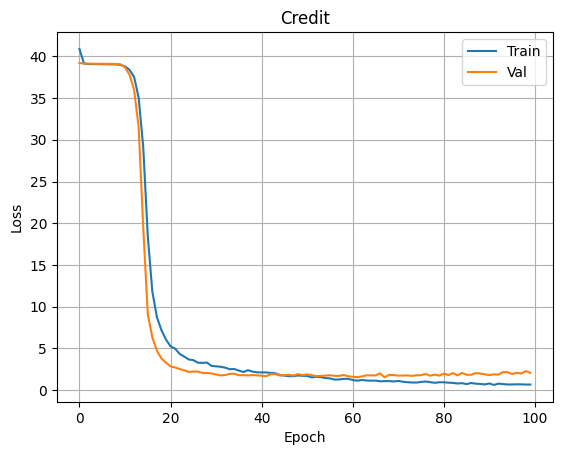

In [ ]:
plot_loss(history, 'Credit')

In [ ]:
model = build_model(
    input_shape=(200, 50, 3),
)

model.compile(optimizer="Adam")


In [ ]:
history = train_and_save(100 , nat_train_dataset,nat_val_dataset, "meli")

Epoch 1/100
50/50 [==============================] - 13s 85ms/step - loss: 27.4731 - val_loss: 25.1690
Epoch 2/100
50/50 [==============================] - 2s 41ms/step - loss: 25.0801 - val_loss: 25.0724
Epoch 3/100
50/50 [==============================] - 2s 44ms/step - loss: 25.0589 - val_loss: 25.0464
Epoch 4/100
50/50 [==============================] - 3s 53ms/step - loss: 25.0437 - val_loss: 25.0379
Epoch 5/100
50/50 [==============================] - 2s 39ms/step - loss: 25.0282 - val_loss: 25.0512
Epoch 6/100
50/50 [==============================] - 2s 39ms/step - loss: 25.0205 - val_loss: 25.0527
Epoch 7/100
50/50 [==============================] - 2s 38ms/step - loss: 25.0240 - val_loss: 25.0261
Epoch 8/100
50/50 [==============================] - 2s 39ms/step - loss: 25.0126 - val_loss: 25.0376
Epoch 9/100
50/50 [==============================] - 4s 75ms/step - loss: 25.0162 - val_loss: 25.0190
Epoch 10/100
50/50 [==============================] - 2s 40ms/step - loss: 25.014

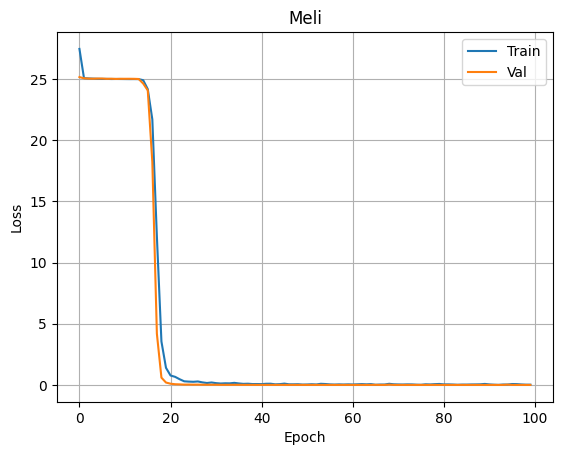

In [ ]:
plot_loss(history, 'Meli')

In [ ]:
def prediction_credit(images):
    result = []
    test_dataset = tf.data.Dataset.from_tensor_slices((images, ['0' * 16] * len(images)))
    test_dataset = (
        test_dataset.map(
            input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
        )
        .batch(16)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

    prediction_model = keras.models.load_model("/content/saved_model_credit", custom_objects={'CTCLayer': CTCLayer})
    prediction_model = keras.models.Model(
        prediction_model.get_layer(name="image").input, prediction_model.get_layer(name="Dense2").output
    )

    for batch in test_dataset.take(1):
        batch_images = batch["image"]
        batch_labels = batch["label"]

        preds = prediction_model.predict(batch_images)
        pred_texts = get_numbers_predictions(preds , 16)

        result = result + pred_texts

    return result

In [ ]:
def prediction_meli(images):
    result = []
    test_dataset = tf.data.Dataset.from_tensor_slices((images, ['0' * 10] * len(images)))
    test_dataset = (
        test_dataset.map(
            input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
        )
        .batch(16)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

    prediction_model = keras.models.load_model("/content/saved_model_meli", custom_objects={'CTCLayer': CTCLayer})
    prediction_model = keras.models.Model(
        prediction_model.get_layer(name="image").input, prediction_model.get_layer(name="Dense2").output
    )

    for batch in test_dataset.take(1):
        batch_images = batch["image"]
        batch_labels = batch["label"]

        preds = prediction_model.predict(batch_images)
        pred_texts = get_numbers_predictions(preds , 10)

        result = result + pred_texts

    return result

1/1 [==============================] - 2s 2s/step


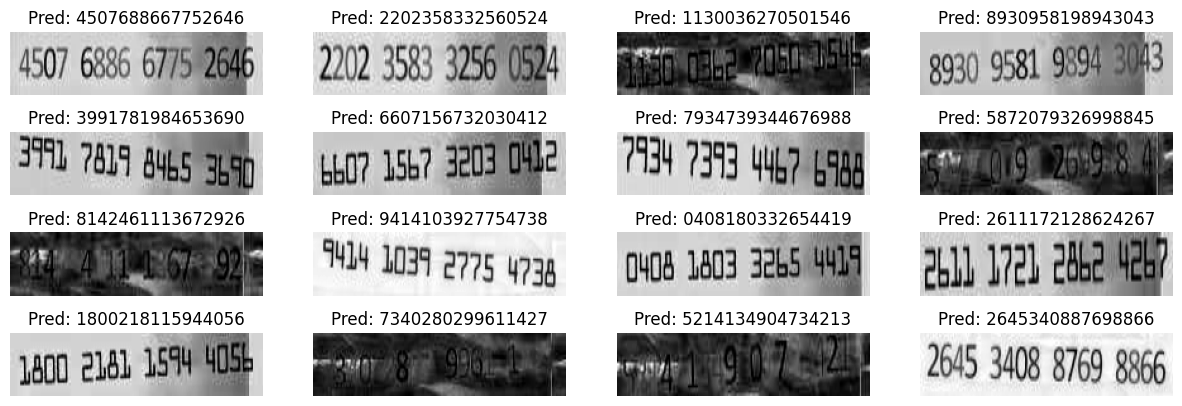

In [ ]:
# result in val data for credit
cred_model = keras.models.load_model("/content/saved_model_credit", custom_objects={'CTCLayer': CTCLayer})
cred_model = keras.models.Model(
    cred_model.get_layer(name="image").input, cred_model.get_layer(name="Dense2").output)

for batch in cred_val_dataset.take(1):
    preds = cred_model.predict(batch['image'])
    pred_texts = get_numbers_predictions(preds, 16)
    plot_result(batch, pred_texts)

1/1 [==============================] - 1s 1s/step


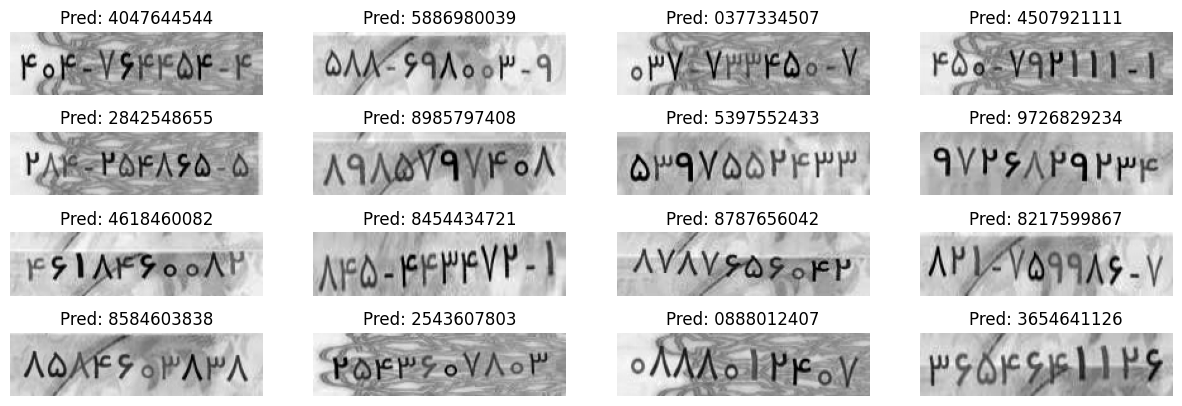

In [ ]:
# result in val data for meli

nat_model = keras.models.load_model("/content/saved_model_meli", custom_objects={'CTCLayer': CTCLayer})
nat_model = keras.models.Model(
    nat_model.get_layer(name="image").input, nat_model.get_layer(name="Dense2").output)

for batch in nat_val_dataset.take(1):
    preds = nat_model.predict(batch['image'])
    pred_texts = get_numbers_predictions(preds, 10)
    plot_result(batch, pred_texts)